# Module 1: Estimate Transition Matrix

* Naive approach
* Estimate with anchor points
* Estimate with consensus patterns

### 1.1. Naive approach
If we know both the ground-truth labels and noisy labels:
$$ \mathbb P(\widetilde Y=j | Y=i) = \frac{\mathbb P(\widetilde Y=j , Y=i)}{\mathbb P(Y=i)} \approx \frac{\text{\#Samples with true label i and noisy label j}}{\text{\#Samples with true label i}} $$


In [73]:
import numpy as np

def est_T_naive(clean_labels, noisy_labels, num_classes):
      T = np.zeros((num_classes, num_classes))
      for i in range(num_classes):
            for j in range(num_classes):
                  T[i][j] = ((clean_labels == i) * (noisy_labels == j)).sum() / (clean_labels == i).sum() # follow the equation
      matrix_with_brackets = '\n'.join(['[ ' + '\t'.join(map(str, row)) + ' ]' for row in T])

      print(f'''T = [
{matrix_with_brackets}
      ]
            ''')

clean_labels = np.array([0, 1, 0, 0, 0, 1, 1, 1])
noisy_labels = np.array([1, 1, 0, 0, 1, 1, 1, 0])
est_T_naive(clean_labels, noisy_labels, num_classes=2)


T = [
[ 0.5	0.5 ]
[ 0.25	0.75 ]
      ]
            


**Challenge:** No clean label $Y$

**Solution:** Can we guess the clean label?

### 1.2. Estimate with anchor points

**Definition: (Anchor points)** ([Xia, et al.](https://arxiv.org/abs/1906.00189), [Liu & Tao](https://arxiv.org/pdf/1411.7718.pdf))
A feature $x$ is an anchor point for the class $i$ if $\mathbb P(Y = i|X=x)$ is equal to one or close to one.

* Step 1: Find the anchor points according to model (train a DNN) predictions (high confidence)
* Step 2 Estimate $\bm T$ with anchor points.

In [74]:
labels_of_anchor_points = np.array([0, 1, 0, 0, 0, 1, 1, 1])
noisy_labels = np.array([1, 1, 0, 0, 1, 1, 1, 0])
est_T_naive(clean_labels=labels_of_anchor_points, noisy_labels=noisy_labels, num_classes=2)

T = [
[ 0.5	0.5 ]
[ 0.25	0.75 ]
      ]
            


### 1.3. Estimate with consensus patterns

#### 1.3.1 What are consensus patterns?

If we have multiple noisy labels per feature:
* 1st-order $(\widetilde Y_1)$
* 2nd-order $(\widetilde Y_1, \widetilde Y_2)$
* 3rd-order $(\widetilde Y_1, \widetilde Y_2, \widetilde Y_3)$
* ...

E.g., $(\widetilde Y_1, \widetilde Y_2, \widetilde Y_3) = (1,1,0)$




#### 1.3.2 Equations (sketch)

**Intuition: Consensus patterns encode $\bm T$.**

$$
\mathbb P(\widetilde Y_1, \widetilde Y_2, \widetilde Y_3) = \textsf{Func}_3(\bm T, \bm p).
$$

* LHS: *Numerical* counts of consensus patterns
* RHS: *Analytical* equations (probabilities)

Let's consider this binary example:
$
\bm T = \begin{pmatrix}
1-e_1 & e_1 \\
e_2 & 1-e_2
\end{pmatrix}
$, $\bm p=[p, 1-p]$

<img src="tutorial_imgs/example-3order.png" width="1200"> 

#### 1.3.3 Code


<img src="tutorial_imgs/consensus_eq.png" width="700"> 

**LHS - Get numerical counts**

```python

# cnt: empirical numbers
for pattern in consensus_patterns:
    cnt[0][pattern[0]] += 1  # 1st order
    cnt[1][pattern[0]][pattern[1]] += 1  # 2nd order
    cnt[2][pattern[0]][pattern[1]][pattern[2]] += 1  # 3rd order

```



**RHS - Prepare analytical equations**

<img src="tutorial_imgs/consensus_eq.png" width="700"> 

```python
# c_analytical: analytical functions

# 1st order equations
c_analytical[0] = torch.mm(T.transpose(0, 1), P).transpose(0, 1) # matrix product between T and p
func_3order = torch.tensor([])
for i in range(KINDS):
    Tr = torch.cat((T[:, i:], T[:, :i]), 1) # T is shifted i columns
    product_2order = torch.mm((T * Tr).transpose(0, 1), P) # element-wise product between T & Tr, then matrix product with p
    
    # 2nd order equations
    c_analytical[1] = torch.cat(
        [c_analytical[1], product_2order], 1) if i != 0 else product_2order
    for j in range(KINDS):
        Ts = torch.cat((T[:, j:], T[:, :j]), 1)
        product_3order = torch.mm((T * Tr * Ts).transpose(0, 1), P) # element/matrix product between T, Tr, Ts, and p
        func_3order = torch.cat([func_3order, product_3order], 1) if j != 0 else product_3order
    # adjust the order of the output (N*N*N), keeping consistent with c_est
    t3 = []
    for p3 in range(KINDS):
        t3 = torch.cat((func_3order[p3, KINDS - p3:], func_3order[p3, :KINDS - p3]))
        func_3order[p3] = t3
    for r in range(KINDS):
        # 3rd order equations
        c_analytical[2][r][(i+r+KINDS) % KINDS] = func_3order[r]

```

#### 1.3.4 Package: Docta
```bash
pip install docta.ai
```

**A Toy Example**
* Synthesize a dataset of 4,000 instances
* Binary classifications
* Each instance has three noisy labels (given by three independent labeler)
* *Task:* Estimate 
  * the label noise transition matrix $\bm T$ 
  * the clean label distribution $\bm p$. 

In [75]:
import numpy as np
np.set_printoptions(precision=3)

# load the data generated in the setup section
clean_labels = np.load("./data/clean_labels.npy")
noisy_labels = np.load("./data/noisy_labels.npy")

# Get the true T
true_T = np.zeros((2,2))
true_p = np.zeros(2)
for i in range(len(clean_labels)):
    for j in range(len(noisy_labels[0])):
        true_T[clean_labels[i]][noisy_labels[i][j]] += 1
    true_p[clean_labels[i]] += 1
true_T /= np.sum(true_T, 1).reshape(-1,1)
true_p /= np.sum(true_p)

# Print the True T and p
print(f"The true T is:\n{true_T}")
print(f"The true p is:\n{true_p}")

The true T is:
[[0.611 0.389]
 [0.203 0.797]]
The true p is:
[0.3 0.7]


Naive Approach: Use majority vote to estimate clean labels

In [76]:
mv_T = np.zeros((2,2))
from collections import Counter
mv_p = np.zeros(2)
for i in range(len(clean_labels)):
    mv_label = Counter(noisy_labels[i]).most_common(1)[0][0] # find the majority
    mv_p[mv_label] += 1 # use the majority as the clean label
    for j in range(len(noisy_labels[0])):
        mv_T[mv_label][noisy_labels[i][j]] += 1

mv_T /= np.sum(mv_T, 1).reshape(-1,1)
mv_p /= np.sum(mv_p)

# Print the estimated T and p
print(f"The estimated T by majority vote is:\n{mv_T}")
print(f"The estimated p by majority vote is:\n{mv_p}")
# Print the True T and p
print("------------------")
print(f"The true T is:\n{true_T}")
print(f"The true p is:\n{true_p}")

The estimated T by majority vote is:
[[0.754 0.246]
 [0.165 0.835]]
The estimated p by majority vote is:
[0.272 0.729]
------------------
The true T is:
[[0.611 0.389]
 [0.203 0.797]]
The true p is:
[0.3 0.7]


Estimate with consensus patterns (by Docta)

In [77]:
from docta.apis import Diagnose
from docta.core.report import Report
from docta.utils.config import Config
import torch

# Load config
cfg = Config.fromfile('./config/toy.py')
np.random.seed(42)
torch.manual_seed(0)

# Initialize the report
report = Report()

# Build a dataset
class MyDataset:
    def __init__(self, consensus_patterns):
        self.consensus_patterns = consensus_patterns
        self.label = np.asarray(noisy_labels)[:,0]

    def __len__(self):
        return len(self.consensus_patterns)

dataset = MyDataset(noisy_labels)

# Estimate T and p
estimator = Diagnose(cfg, dataset, report=report)
estimator.hoc()

# Print the estimated T and p
print(f"The estimated T by Docta is:\n{report.diagnose['T']}")
print(f"The estimated p by Docta is:\n{report.diagnose['p_clean'].reshape(-1)}")
# Print the True T and p
print("------------------")
print(f"The true T is:\n{true_T}")
print(f"The true p is:\n{true_p}")


Estimating consensus patterns...


  5%|▌         | 1/20 [00:00<00:02,  7.42it/s]

100%|██████████| 20/20 [00:02<00:00,  9.84it/s]


Estimating consensus patterns... [Done]
Use cpu to solve equations


100%|██████████| 1501/1501 [00:02<00:00, 608.97it/s]

Solve equations... [Done]
The estimated T by Docta is:
[[0.601 0.399]
 [0.213 0.787]]
The estimated p by Docta is:
[0.293 0.707]
------------------
The true T is:
[[0.611 0.389]
 [0.203 0.797]]
The true p is:
[0.3 0.7]


#### 1.3.5 Practical Cases: One label per feature


Condition: $2$-NN label clusterability

**Definition: (Clusterability)**
A dataset $D$ satisfies $k$-NN label clusterability if $\forall n \in [N]$, the feature $x_n$ and its $k$-Nearest-Neighbor $x_{n_1}, \cdots, x_{n_k}$ belong to the same true label class.

<img src="tutorial_imgs/clusterability.png" width="700"> 

*Figure: Illustration of $k$-NN label clusterability.*

**Properties**
* $k_1$-NN label clusterability is *harder* than $k_2$-NN label clusterability when $k_1 > k_2$;
* The cluster containing the same clean labels is not required to be a continuum, e.g., two clusters of class ``1'' can be far away;
* The $k$-NN label clusterability only requires the existence of these feasible points, i.e., specifying the true class is not necessary.

#### Algorithms
* Step 1: Get embeddings of original features
  * Good embedding (from contrastive learning, meta-learning, pre-trained models): 
    * 2-NN label clusterability
  * Improve embedding [(Zhu et al.)](https://arxiv.org/abs/2202.01273):
    * feature engineering 
    * reweight with f-mutual information
* Step 2: Find (noisy) labels of 2-NN

<img src="tutorial_imgs/hoc-step2.png" width="500"> 

* Step 3: Check label consensuses of 2-NN features
* Step 4: Solve equations



## Module 2. Find label errors

**Two Philosophies:**
* Learning-Centric Method (2.1, 2.2)
  * *Memorization Effect*: DNNs first learn easy (clean) patterns, then learn difficult (hard) patterns 
* Data-Centric Method (2.3)
  * *Neighborhood Information*: k-NN label clusterability (nearby features have the same true label)

### 2.1. Detect with model prediction

**Model Confidence**: The largest probability predicted by model (per sample)

For example, consider a binary classification. After the final linear layer, the model output on feature $x_n$ is
$$
\bm f(x_n) = \begin{pmatrix} 0.8 \\ 0.2\end{pmatrix}
$$
Then
$$
    \texttt{Confidence} = \max_{i\in \{1,2\}} f{(x_n)}[i] = 0.8.
$$



**Idea:** Trust model predictions if confidence is high (e.g., > 0.8)

**Algorithm (Sketch):**
* Divide the noisy training dataset into two parts: $\widetilde D_1, \widetilde D_2$
* Train model $f_1$ on $\widetilde D_1$. Use $f_1$ to predict on $\widetilde D_2$. 
* Find the samples whose label disagree with model predictions and model confidence is larger than threshold.


  
  


### 2.2. Detect with instance influence
**Instance Influence**: The influence of instance-$i$ to instance-$j$ on model predictions.

<img src="tutorial_imgs/infl_def.png" width="800"> 


**Idea:** 
* Easy (clean) patterns --> Low influence
* Difficult (wrong) patterns --> High influence


**Estimate Influence During Training**

<img src="tutorial_imgs/infl_approximation.png" width="1000"> 


**Algorithm (Sketch):**
* Train model $f$ on noisy dataset. Record gradients caused by each point. 
* Calculate influence of instance-i $\sum_j \text{infl}_f(D,i,j)$.
* Filter out points whose influence is larger than threshold.

### 2.3. Detect with similar features

**Similar Features**: $k$-NN features.

**Requirement**: $k$-NN label clusterability

<img src="tutorial_imgs/clusterability.png" width="700"> 

**Idea**:
* Score all the instances relying on $k$-NN information (higher --> clean)
* Sort the instances according to scores
* Set threshold and filter out low-score points

<img src="tutorial_imgs/simifeat_detection.png" width="1200"> 

**Score Function**

<img src="tutorial_imgs/simifeat_score.png" width="1000"> 

**Threshold**

<img src="tutorial_imgs/simifeat_threshold.png" width="1000"> 

### 2.4. Example with Docta


#### 2.4.1 Dataset 
We will adopt the Iris dataset for illustration.

**Basic information**
The Iris data includes three iris species with 50 samples each as well as some properties about each flower. Here is a display of the main features/labels of the iris dataset.

In [78]:
import pandas as pd
base_path = './data/'
clean_iris = pd.read_csv(base_path + 'clean_Iris.csv')
clean_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,83,5.8,2.7,3.9,1.2,Iris-versicolor
1,132,7.9,3.8,6.4,2.0,Iris-virginica
2,93,5.8,2.6,4.0,1.2,Iris-versicolor
3,29,5.2,3.4,1.4,0.2,Iris-setosa
4,12,4.8,3.4,1.6,0.2,Iris-setosa


The column ``Id`` indicates the raw index of the sample in the [official Iris dataset](https://archive.ics.uci.edu/dataset/53/iris). As displayed in the above table, there are four key compenents (features) for categorizing the species of the iris flower: ``SepalLengthCm``, ``SepalWidthCm``, ``PetalLengthCm``, ``PetalWidthCm``.

#### 2.4.2 Synthesize label noise 

The following function gives an example pipeline for preparing a dataset for Docta treatment.

In [79]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def process_csv(file_path, e=0.2):
    """
    Input:
      file_path: a raw file path of your csv file that you want to process
      e: the percentage of label errors to simulate
      (in this Iris data, we use the clean label to simulate label errors)
    Output:
      df: a processed csv files with label errors,
          each column denotes a kind of feature (changed to nemerical ones if not),
          except for the last one which is the (noisy) target column.
      clean_label: this is the clean target reserved for checking the Docta performances
    """
    # Load your data
    df = pd.read_csv(file_path)

    # (1) Rename the last column to 'clean_target'
    df.rename(columns={df.columns[-1]: 'clean_target'}, inplace=True)

    # (2) If 'clean_target' column is not of integer type, convert it
    if df['clean_target'].dtype != 'int':
        le = LabelEncoder()
        df['clean_target'] = le.fit_transform(df['clean_target'])

    # (3) Convert other columns to numerical values if they are not already
    for col in df.columns[:-1]:  # Exclude the last column
        if df[col].dtype == 'object':  # If the column has text
            df[col] = le.fit_transform(df[col])  # Convert text to integer

    # (4) Add a new 'target' column
    n_unique = df['clean_target'].nunique()
    def generate_target(val):
        rand_val = np.random.random()
        if rand_val < e:
            new_val = np.random.choice([i for i in range(n_unique) if i != val])
        else:
            new_val = val
        return new_val

    df['target'] = df['clean_target'].apply(generate_target)
    accuracy = (df['target'] == df['clean_target']).mean() * 100
    # Print the accuracy
    print(f"Label error rate: {100 - accuracy:.2f}%")
    clean_label = df['clean_target'].tolist()
    # Remove the clean label
    df = df.drop(columns=['Id', 'clean_target'], axis=1)

    return df, clean_label

Synthesize and save the noise data

In [80]:
np.random.seed(42)
noisy_df, clean_label = process_csv(base_path + 'clean_Iris.csv', e=0.25)
noisy_df.to_csv(base_path + 'noisy_Iris.csv', index=False)


Label error rate: 27.33%


#### Detect label errors with Docta.ai

In [81]:
from docta.utils.config import Config
from docta.datasets import TabularDataset
import torch
# Load config
cfg = Config.fromfile('./config/label_error_tabular.py')

np.random.seed(42)
torch.manual_seed(0)
dataset = TabularDataset(root_path=cfg.data_root, normalize=False)
cfg.num_classes = len(np.unique(dataset.label))
test_dataset = None
print('Tabular-data load finished')

from docta.apis import DetectLabel
from docta.core.report import Report
# Initialize the report
report = Report()
# Initialize the detector
detector = DetectLabel(cfg, dataset, report=report)
# Detection
detector.detect()

Tabular-data load finished
Detecting label errors with simifeat.
Estimating consensus patterns...


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 173.48it/s]


Estimating consensus patterns... [Done]
Use cpu to solve equations


100%|██████████| 501/501 [00:01<00:00, 341.45it/s]


Solve equations... [Done]
Use SimiFeat-rank to detect label errors.


100%|██████████| 51/51 [00:00<00:00, 917.31it/s]

[SimiFeat] We find 48 corrupted instances from 150 instances


#### 2.4.3 Check the label error detection/curation results

For each row, it contains the information of (**sample index & Docta suggested label & the confidence of the suggestion**)

In [82]:
cured = report.curation['label_curation']
print(cured[0]) # we will see a three-tuple

[117, 0, 0.942684766214178]


#### Cure the dataset according to Docta's report

In [83]:
# This function takes the docta report, cured labels, and y_noisy as input, outputs a corrected y_train
import numpy as np
def cure_y_train(y_noisy, cured_report, thres = 0.8):
    y_noisy_copy = np.copy(y_noisy)
    cnt = 0
    for report in cured_report:
        a, b, c = report
        if c > thres:
            y_noisy_copy[a] = b
            cnt += 1
    return y_noisy_copy, cnt

In [84]:
docta_labels, n_cured_labels = cure_y_train(noisy_df['target'].tolist(), cured)
noisy_df['docta_labels'] = docta_labels
print(f"Docta cured {n_cured_labels} potential label errors!")
noisy_df.head()

Docta cured 30 potential label errors!


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,target,docta_labels
0,5.8,2.7,3.9,1.2,1,1
1,7.9,3.8,6.4,2.0,2,1
2,5.8,2.6,4.0,1.2,1,1
3,5.2,3.4,1.4,0.2,0,0
4,4.8,3.4,1.6,0.2,1,1


#### Take a look at the transition matrix comparisons

In [89]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_noisy = noisy_df['target'].to_numpy()
noisy_cm = confusion_matrix(clean_label, y_noisy)
docta_cm = confusion_matrix(clean_label, docta_labels)
print(f"The transition matrix between clean labels and the raw noisy labels is:\n{noisy_cm}\nAnd number of label errors is {int(len(clean_label)*(1-accuracy_score(clean_label, y_noisy)))}")
print("-----------"*7)
print(f"The transition matrix between clean labels and the docta curated labels is:\n{docta_cm}\nAnd number of label errors is {int(len(clean_label)*(1-accuracy_score(clean_label, docta_labels)))}")

true_label_errors = clean_label != y_noisy
docta_label_errors = docta_labels != y_noisy
precision = np.sum(true_label_errors * docta_label_errors) / np.sum(docta_label_errors)
recall = np.sum(true_label_errors * docta_label_errors) / np.sum(true_label_errors)
fscore = 2*precision*recall/(precision+recall)
print(f"Takeaway: \n1. Docta has found {n_cured_labels} potential label errors. \n2. Precision: {precision}. Recall: {recall}. fscore: {fscore}")

The transition matrix between clean labels and the raw noisy labels is:
[[34 11  5]
 [ 7 38  5]
 [ 6  7 37]]
And number of label errors is 41
-----------------------------------------------------------------------------
The transition matrix between clean labels and the docta curated labels is:
[[43  6  1]
 [ 3 46  1]
 [ 2  3 45]]
And number of label errors is 16
Takeaway: 
1. Docta has found 30 potential label errors. 
2. Precision: 0.9333333333333333. Recall: 0.6829268292682927. fscore: 0.7887323943661972


#### Visualize the curation

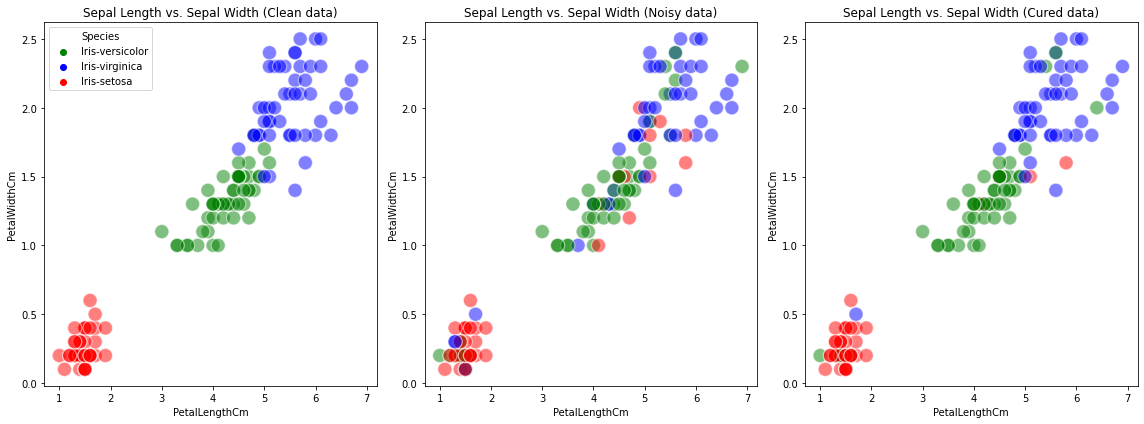

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

color_mapping = {"Iris-setosa": "red", "Iris-versicolor": "green", "Iris-virginica": "blue"}
fig = plt.figure(figsize=(16, 6))  # Create a figure
# SepalLengthCm v.s. SepalWidthCm
ax1 = plt.subplot(131)
sns.scatterplot(data=clean_iris, x="PetalLengthCm", y="PetalWidthCm", hue="Species", palette=color_mapping, ax=ax1, s=200, alpha=0.5)
ax1.set_title("Sepal Length vs. Sepal Width (Clean data)")

color_mapping_noise = {1: "green", 2: "blue", 0: "red"}

ax2 = plt.subplot(132)
sns.scatterplot(data=noisy_df, x="PetalLengthCm", y="PetalWidthCm", hue="target", palette=color_mapping_noise,  ax=ax2, legend=False, s=200, alpha=0.5)
ax2.set_title("Sepal Length vs. Sepal Width (Noisy data)")

ax3 = plt.subplot(133)
sns.scatterplot(data=noisy_df, x="PetalLengthCm", y="PetalWidthCm", hue="docta_labels", palette=color_mapping_noise,  ax=ax3, legend=False, s=200, alpha=0.5)
ax3.set_title("Sepal Length vs. Sepal Width (Cured data)")

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()